In [62]:
from __future__ import absolute_import, division, print_function
import os
from scipy.io import loadmat
import arff
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


from sklearn.svm import NuSVC, SVC
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

In [39]:
foldnum = 1
codebook = 4096
feat_path = os.path.join('baseline_boaw/feat/')
meta_path = os.path.join('..','..','feature','mfcc')


scaler = StandardScaler()

X = dict()
y = dict()

for subset in ['train','dev']:
    BOAW_feat = os.path.join(feat_path,
                             'fold%d.%s.%d.arff' % (foldnum,subset,codebook))
    BOAW_meta = os.path.join(meta_path,'fold%d.%s.filenames.txt' % (foldnum,subset))
    print(BOAW_feat)
    print(os.path.isfile(BOAW_meta))
    
    df = arff.load(open(BOAW_feat,'r'))
    boawData = pd.DataFrame(np.array(df['data'],dtype=float))
    del df

    boawFilenames = []
    with open(BOAW_meta, 'r') as fp:
        line = fp.readline()
        boawFilenames.append(line.split('\n')[0])
        while line:
                line = fp.readline()
                boawFilenames.append(line.split('\n')[0])
    boawFilenames = boawFilenames[:-1]
    boawData['filenames'] = boawFilenames
    boawData.rename({len(boawData.columns)-2:'label'},axis='columns',inplace=True)
    boawData.label = [int(each) for each in boawData.label]
    boawData['dataset'] = [each[-1][0] for each in boawData.filenames.str.split('_')]
    boawData.set_index('filenames',drop=True,inplace=True)

    del boawFilenames
    
    X[subset] = scaler.fit_transform(boawData[range(4096)].values)
    y[subset] = boawData.label.values
    
    del boawData
    
X_train = X['train']
X_val = X['dev']
y_train = y['train']
y_val = y['dev']

del X,y

baseline_boaw/feat/fold1.train.4096.arff
True
baseline_boaw/feat/fold1.dev.4096.arff
True


In [55]:
def verboseMetrics(y_val,softScores):
    eps = 1.1e-5
    if Counter(y_val).keys()[-1] == 1:
        TN, FP, FN, TP = confusion_matrix(y_val, np.argmax(softScores,axis=-1), labels=[0,1]).ravel()
        sensitivity = TP / (TP + FN + eps)
        specificity = TN / (TN + FP + eps)
        precision = TP / (TP + FP + eps)
        F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
        Macc = (sensitivity + specificity) / 2
        print("TN:{},FP:{},FN:{},TP:{},Sensitivity:{},Specificity{},Macc:{},F1:{}".format(TN, FP, FN, TP,sensitivity,specificity,Macc,F1))
        return Macc
    elif Counter(y_val).keys()[-1] == 2:
        logs = dict()
        confmat = confusion_matrix(y_pred=np.argmax(softScores,axis=-1), y_true=y_val)
        logs['recall0'] = confmat[0, 0] / np.sum(confmat[0, :])
        logs['recall1'] = confmat[1, 1] / np.sum(confmat[1, :])
        logs['recall2'] = confmat[2, 2] / np.sum(confmat[2, :])
        logs['UAR'] = np.mean([logs['recall0'], logs['recall1'], logs['recall2']])
        print(logs.items())

## Undersampling

In [48]:
## BOAW Train

n_estimators = 100
rand_state = 1

clf = NuSVC(kernel='linear',probability=True,verbose=False,
          random_state=rand_state,
            nu = .5)

boawBbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=n_estimators,
                                oob_score = True,
                                random_state=rand_state,
                                sampling_strategy = 'not minority'
                               )
boawBbc.fit(X_train,y_train)
# print("Out of Bag Score Boaw %f" % boawBbc.oob_score_)
# print("Validation split accuracy Boaw %f" % accuracy_score(y_val,boawBbc.predict(X_val)))
verboseMetrics(y_val,boawBbc.predict_proba(X_val))

Out of Bag Score Boaw 0.840982
Validation split accuracy Boaw 0.809942
TN:161,FP:10,FN:55,TP:116,Sensitivity:0.678362529462,Specificity0.941520407271,Macc:0.809941468366,F1:0.781139349582


In [53]:
np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train,y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=False,
              random_state=rand_state, nu = .5)
    
    print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val))
    results.append(verboseMetrics(y_val,softScores[-1]))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

init = np.asarray(np.zeros((342,2)))
for each in softScores:
    init+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,init)

sns.distplot(results,20)
plt.show()

Training SVM 0
TN:154,FP:17,FN:39,TP:132,Sensitivity:0.771929774905,Specificity0.900584737389,Macc:0.836257256147,F1:0.824994469314
Training SVM 1
TN:155,FP:16,FN:43,TP:128,Sensitivity:0.748537963544,Specificity0.906432690229,Macc:0.827485326887,F1:0.812692896383
Training SVM 2
TN:162,FP:9,FN:46,TP:125,Sensitivity:0.730994105024,Specificity0.947368360111,Macc:0.839181232567,F1:0.819666653
Training SVM 3
TN:157,FP:14,FN:51,TP:120,Sensitivity:0.701754340823,Specificity0.91812859591,Macc:0.809941468366,F1:0.786879770121
Training SVM 4
TN:160,FP:11,FN:48,TP:123,Sensitivity:0.719298199343,Specificity0.93567245443,Macc:0.827485326887,F1:0.806551899848
Training SVM 5
TN:159,FP:12,FN:48,TP:123,Sensitivity:0.719298199343,Specificity0.92982450159,Macc:0.824561350467,F1:0.80391608699
Training SVM 6
TN:157,FP:14,FN:42,TP:129,Sensitivity:0.754385916385,Specificity0.91812859591,Macc:0.836257256147,F1:0.821650537157
Training SVM 7
TN:161,FP:10,FN:42,TP:129,Sensitivity:0.754385916385,Specificity0.9415

TN:158,FP:13,FN:50,TP:121,Sensitivity:0.707602293663,Specificity0.92397654875,Macc:0.815789421207,F1:0.793437146697
Training SVM 63
TN:155,FP:16,FN:49,TP:122,Sensitivity:0.713450246503,Specificity0.906432690229,Macc:0.809941468366,F1:0.789638519492
Training SVM 64
TN:157,FP:14,FN:47,TP:124,Sensitivity:0.725146152184,Specificity0.91812859591,Macc:0.821637374047,F1:0.802583502388
Training SVM 65
TN:161,FP:10,FN:43,TP:128,Sensitivity:0.748537963544,Specificity0.941520407271,Macc:0.845029185407,F1:0.828473468181
Training SVM 66
TN:162,FP:9,FN:41,TP:130,Sensitivity:0.760233869225,Specificity0.947368360111,Macc:0.853801114668,F1:0.838704176539
Training SVM 67
TN:159,FP:12,FN:51,TP:120,Sensitivity:0.701754340823,Specificity0.92982450159,Macc:0.815789421207,F1:0.792073741566
Training SVM 68
TN:158,FP:13,FN:44,TP:127,Sensitivity:0.742690010704,Specificity0.92397654875,Macc:0.833333279727,F1:0.816714754143
Training SVM 69
TN:158,FP:13,FN:46,TP:125,Sensitivity:0.730994105024,Specificity0.92397654

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [57]:
init = np.asarray(np.zeros((342,2)))
for each in softScores:
    init+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,init)

# sns.distplot(results,20)
# plt.show()

Posterior Fusion Score:
TN:158,FP:13,FN:46,TP:125,Sensitivity:0.730994105024,Specificity0.92397654875,Macc:0.827485326887,F1:0.809055993836


0.8274853268869088

## OverSampling

Training SVM 0
TN:163,FP:8,FN:68,TP:103,Sensitivity:0.60233914254,Specificity0.953216312951,Macc:0.777777727745,F1:0.730491145931
Training SVM 1
TN:166,FP:5,FN:74,TP:97,Sensitivity:0.567251425498,Specificity0.970760171472,Macc:0.769005798485,F1:0.71061750474
Training SVM 2
TN:167,FP:4,FN:77,TP:94,Sensitivity:0.549707566978,Specificity0.976608124312,Macc:0.763157845645,F1:0.698879606289
Training SVM 3
TN:164,FP:7,FN:72,TP:99,Sensitivity:0.578947331179,Specificity0.959064265791,Macc:0.769005798485,F1:0.714796190161
Training SVM 4
TN:164,FP:7,FN:69,TP:102,Sensitivity:0.596491189699,Specificity0.959064265791,Macc:0.777777727745,F1:0.728566141032
0.7713449796210832
0.005669800638102118
Posterior Fusion Score:
TN:165,FP:6,FN:70,TP:101,Sensitivity:0.590643236859,Specificity0.964912218631,Macc:0.777777727745,F1:0.726613439067


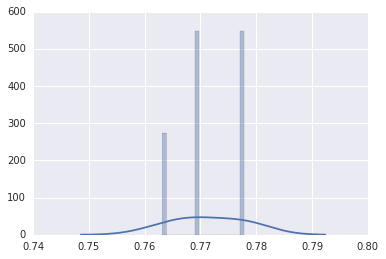

In [63]:
n_estimators = 5

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train,y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=False,
              random_state=rand_state, nu = .5)
    
    print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val))
    results.append(verboseMetrics(y_val,softScores[-1]))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

init = np.asarray(np.zeros((342,2)))
for each in softScores:
    init+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,init)

sns.distplot(results)
plt.show()

In [65]:
softScores_boaw = softScores

In [66]:
FBANK_feat = os.path.join('FBANK','binnedFeat.mat')
FBANK_label = os.path.join('FBANK','binnedLabels.csv')
ComParE_feat = os.path.join('baseline','openSMILEall_PCG.mat')